# Lab 2: Training Loop

In this notebook, we'll implement the training loop — the core algorithm that makes our model learn. By the end, our model will discover the correct `weight = 0.4` and `bias = 0.1` values from the data.

## Install Dependencies

Run this cell to install the required libraries.

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install matplotlib

Looking in indexes: https://download.pytorch.org/whl/cpu


## Setup from Lab 1

Before we start training, we need to recreate everything from Lab 1: the data, model, and plotting function. Run this cell to set up the environment.

![Linear Model](https://raw.githubusercontent.com/poridhiEng/lab-asset/7008e578e0c9c57813d1b267134700911793d762/tensorcode/Deep-learning-with-pytorch/LinearRegression/lab-02/images/linear-model.svg)

The diagram shows how our `LinearRegressionModel` works:
- **Input X** → The model receives input features
- **Multiply (X × weights)** → Input is multiplied by the learnable weight parameter
- **Add (+ bias)** → The learnable bias parameter is added to the result
- **Output y_pred** → The final prediction

The model computes: `forward(X) = X × weights + bias`

Currently, the model starts with **random values** for weights and bias. Our goal in this lab is to train it to discover the correct values: `weight = 0.4` and `bias = 0.1`.

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

torch.manual_seed(42)

# Target parameters (what we want the model to learn)
weight = 0.4
bias = 0.1

# Create data
X = torch.arange(0, 1, 0.02).unsqueeze(dim=1)
y = weight * X + bias

# Train/test split (80/20)
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

# Model definition
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1), requires_grad=True)

    def forward(self, x):
        return self.weight * x + self.bias

# Plotting function
def plot_predictions(train_data, train_labels, test_data, test_labels, predictions=None):
    plt.figure(figsize=(10, 7))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    plt.scatter(test_data, test_labels, c="r", s=4, label="Test data")
    if predictions is not None:
        plt.scatter(test_data, predictions, c="g", s=4, label="Predictions")
    plt.legend()
    plt.xlabel("X")
    plt.ylabel("y")
    plt.show()

# Create model instance
model = LinearRegressionModel()

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"Initial parameters: weight={model.weight.item():.4f}, bias={model.bias.item():.4f}")

# 3️⃣ {model.weight.item():.4f} ভেঙে বুঝি
# এটা ৩টা অংশে ভাগ করা যায়:
# 🧩 (a) model.weight
# এটা তোমার neural network model এর weight parameter
# 🧩 (b) .item()
# PyTorch এ weight/bias সাধারণত tensor হয়।
# .item() tensor থেকে একটা সাধারণ number (float) বের করে।

print(f"Target parameters:  weight={weight}, bias={bias}")

Training samples: 40, Test samples: 10
Initial parameters: weight=0.3367, bias=0.1288
Target parameters:  weight=0.4, bias=0.1


## 1. Create Loss Function

A **loss function** measures how wrong our predictions are. We use Mean Absolute Error (MAE), also called L1 Loss. It calculates the average absolute difference between predictions and actual values.

Lower loss = better predictions.

In [ ]:
# Create loss function L1Loss মানে = Mean Absolute Error (MAE)
loss_fn = nn.L1Loss()

# Example: calculate loss between some predictions and targets
example_preds = torch.tensor([0.5, 0.6, 0.7])
example_targets = torch.tensor([0.4, 0.5, 0.8])
example_loss = loss_fn(example_preds, example_targets)
print(f"Example loss: {example_loss}")

Example loss: 0.10000001639127731


## 2. Create Optimizer

An **optimizer** updates parameters based on gradients to reduce the loss. We use SGD (Stochastic Gradient Descent) with a learning rate of 0.01.

The learning rate controls how big each update step is — too high and we overshoot, too low and training takes forever.


Nice, deep learning mood on

**Optimizer** হলো সেই জিনিসটা যেটা তোমার মডেলকে **ভুল থেকে শিখতে সাহায্য করে**।

সহজ ভাষায়:
👉 **Optimizer = model এর “marks কমানোর মেশিন”**

---

## 🧠 আগে ছোট্ট flow টা বুঝি

Training এর সময় ৪টা জিনিস কাজ করে:

1. **Model** → prediction দেয়
2. **Loss Function** → বলে prediction কতটা ভুল
3. **Backpropagation** → বলে কোন weight কতটা দায়ী
4. **Optimizer** → weight গুলো ঠিক করে দেয়

---

## 🎯 Optimizer আসলে কী করে?

Model এর ভিতরে অনেক **weights (parameters)** থাকে।
Optimizer এদের আপডেট করে এইভাবে:

```
নতুন weight = পুরানো weight - (learning rate × gradient)
```

মানে —
ভুল যেদিকে বেশি, optimizer সেদিক থেকে weight সরিয়ে নেয় যাতে loss কমে।

---


| Optimizer                             | কেমন কাজ করে              | কখন ভালো                  |
| ------------------------------------- | ------------------------- | ------------------------- |
| **SGD** (Stochastic Gradient Descent) | সোজা gradient দিয়ে update | Simple case               |
| **Momentum**                          | আগের direction মনে রাখে   | Faster learning           |
| **RMSprop**                           | learning rate adjust করে  | Noisy data                |
| **Adam** ⭐                            | Momentum + RMSprop combo  | Most popular, works great |

👉 Beginners দের জন্য **Adam = safest choice**

---

## 🧪 PyTorch এ Optimizer example

```python
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001)
```

এখানে:

* `model.parameters()` → কোন weight গুলো update হবে
* `lr` → learning rate (কত বড় step নেবে)

Training loop এ:

```python
optimizer.zero_grad()   # পুরানো gradient মুছে ফেলা
loss.backward()         # gradient বের করা
optimizer.step()        # weight update করা (optimizer কাজ করে এখানে)
```



In [ ]:
# Create optimizer
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

print(f"Optimizer: {optimizer}")

Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


## 3. The Training Loop

Now we implement the 5-step training loop. This is the core algorithm that makes learning happen:

1. **Zero gradients** — Clear old gradients (PyTorch accumulates them by default)
2. **Forward pass** — Make predictions with current parameters
3. **Calculate loss** — Measure how wrong predictions are
4. **Backward pass** — Compute gradients (how to adjust parameters)
5. **Update parameters** — Adjust weights using gradients

We repeat this for 100 epochs (complete passes through the data).

**Note on model modes:**
- `model.train()` — Sets the model to training mode (enables dropout, batch normalization behavior for training)
- `model.eval()` — Sets the model to evaluation mode (disables those features for inference)

For our simple linear model, these don't change behavior, but it's good practice to use them consistently.

In [ ]:
epochs = 100

epoch_count = []
train_loss_values = []
test_loss_values = []

for epoch in range(epochs):
    model.train()         #training mode on

    # 1. Zero gradients ---------- PyTorch এ gradients previous step থেকে accumulate হয়, তাই প্রতিটি step এ zero করতে হবে।
    optimizer.zero_grad()

    # 2. Forward pass
    y_pred = model(X_train)

    # 3. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 4. Backward pass                 Backpropagation শুরু হয় → gradients calculate করে সব parameter এর জন্য।
    loss.backward()

    # 5. Update parameters
    optimizer.step()

    # Evaluate on test set
    model.eval()                  #Evaluation mode on

    with torch.inference_mode():                #gradient computation বন্ধ → memory সাশ্রয়।
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, y_test)

    # Record losses every 10 epochs (for smoother plotting)
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().numpy())
        test_loss_values.append(test_loss.detach().numpy())
        print(f"Epoch {epoch:3d} | Train Loss: {loss:.4f} | Test Loss: {test_loss:.4f}")

Epoch   0 | Train Loss: 0.0130 | Test Loss: 0.0278
Epoch  10 | Train Loss: 0.0095 | Test Loss: 0.0216
Epoch  20 | Train Loss: 0.0060 | Test Loss: 0.0133
Epoch  30 | Train Loss: 0.0026 | Test Loss: 0.0051
Epoch  40 | Train Loss: 0.0077 | Test Loss: 0.0026
Epoch  50 | Train Loss: 0.0077 | Test Loss: 0.0026
Epoch  60 | Train Loss: 0.0077 | Test Loss: 0.0026
Epoch  70 | Train Loss: 0.0077 | Test Loss: 0.0026
Epoch  80 | Train Loss: 0.0077 | Test Loss: 0.0026
Epoch  90 | Train Loss: 0.0077 | Test Loss: 0.0026


## Visualizing Loss Curves

Loss curves show how the model improves over time. Both train and test loss should decrease together.

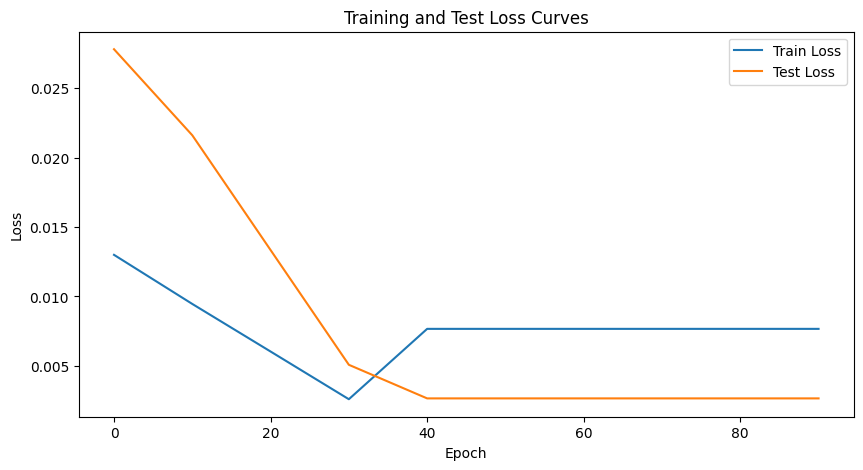

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epoch_count, train_loss_values, label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss Curves")
plt.legend()
plt.show()

## Comparing Learned vs Target Parameters

Let's see how close our model got to the true weight and bias values.

In [ ]:
print("Learned parameters:")
print(model.state_dict())

print(f"\nComparison:")
print(f"  Learned weight: {model.state_dict()['weight'].item():.4f} | Target: {weight}")
print(f"  Learned bias:   {model.state_dict()['bias'].item():.4f} | Target: {bias}")

Learned parameters:
OrderedDict({'weight': tensor([0.3937]), 'bias': tensor([0.0948])})

Comparison:
  Learned weight: 0.3937 | Target: 0.4
  Learned bias:   0.0948 | Target: 0.1


The learned parameters should be very close to the target values (weight=0.4, bias=0.1)!

## Visualizing Final Predictions

Now let's see how well our trained model predicts on the test data.

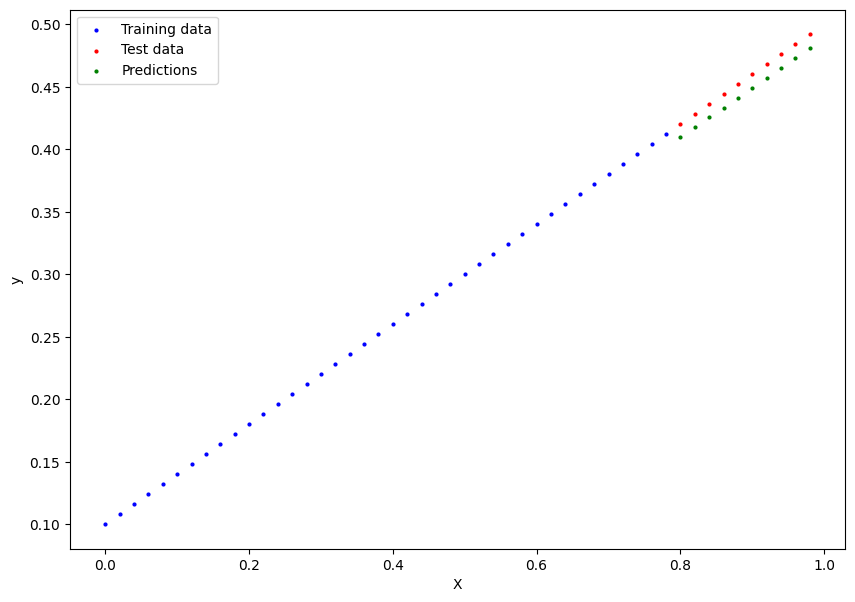

In [ ]:
# Make final predictions
model.eval()
with torch.inference_mode():
    final_preds = model(X_test)

# Plot predictions
plot_predictions(X_train, y_train, X_test, y_test, predictions=final_preds)

The green dots (predictions) should now align closely with the test data. Our model has learned the pattern!

## Summary

In this lab, we:
1. Created a **loss function** (L1Loss/MAE) to measure prediction errors
2. Created an **optimizer** (SGD with lr=0.01) to update parameters
3. Implemented the **5-step training loop**
4. Trained for **100 epochs** and watched the loss decrease
5. Verified our model learned `weight ≈ 0.4` and `bias ≈ 0.1`

In **Lab 3**, we'll save this trained model to disk and load it back for future use.